# SpotDraft Test

## Task Definition :

#### In this test, you are tasked with building a classifier which classifies a given piece of text.
#### The dataset for this task has the following format:
    1. train : list of 10000 tuples of class_name and text for training
    2. test : list of 1000 tuples of class_name and text for testing
    

### Use the provided data to build and test a text classifier. You are free to choose anything. One model, n models, ensemble of models, NN, anything that works for you. 

### Submission :
1. A working notebook in a saved state with instructions to reproduce it.
2. [Optional but highly recommended] Accuracy and/or loss graph on train and test data during training
3. Accuracy measures on train and test data
4. Plot of confusion matrix for train and test datasets
5. [ROC curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
    

### Evaluation : 

#### Your submission will be evaluated on these metrics:
1. Choice of the tools for the task
2. Preprocessing steps
3. Feature creation/selection/combination
4. Model(s) chosen
5. Evaluation metric
6. Hyperparamer choices
7. <s> Accuracy</s>
8. *Ability to communicate results*

In [1]:
import pickle

In [2]:
train = pickle.load(open("./small_data_text_classifier_train.pkl",'rb'))

In [3]:
test = pickle.load(open("./small_data_text_classifier_test.pkl",'rb'))

### Submission starts here. Good luck!

### Import Libraries

In [44]:
import pandas as pd
# import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
import numpy as np
import os
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re
import string
import itertools
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit,KFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn import linear_model


%matplotlib inline

In [5]:
train = pd.DataFrame(train,columns=['Class','Text'])
test = pd.DataFrame(test,columns=['Class','Text'])


In [6]:
train.isnull().sum() , test.isnull().sum() 

(Class    0
 Text     0
 dtype: int64, Class    0
 Text     0
 dtype: int64)

In [7]:
stop = set(stopwords.words('english'))
stop.remove('not')

### Feature Engineering and Cleaning of data

In [8]:
def cleanup(s):                      
    """
    function to clean text data
    
    """
    s = str(s)
    s = s.lower()
    s = re.sub("https\S+\w+","",s)
    s = re.sub('rt*.@\w+',' ',s)
    s = re.sub('@\w+',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w,]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', s)
    s = s.replace(".co","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    s = ''.join(''.join(a)[:2] for _, a in itertools.groupby(s))
    s = [w for w in s.split() if not w in stop]
    s = " ".join(s)
    return s

In [9]:
def extraFeature(df,textcol = None):
    """Create meta features"""
    
    df['count_dgits'] = df[textcol].apply(lambda s : sum(map(str.isdigit, s)))
    df[textcol] = df[textcol].apply(cleanup)# applying cleanup 
#     df["count_punctuations"] =df[textcol].apply(lambda x: len([c for c in str(x) if c in string.punctuation])) #not helping
    df['count_unique_word']=df[textcol].apply(lambda x: len(set(str(x).split())))
    df['count_word']=df[textcol].apply(lambda x: len(str(x).split()))
    df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
    
    return df
    
    

In [10]:
extraFeature(train,"Text")
train.head(10)

,Class,Text,count_dgits,count_unique_word,count_word,word_unique_percent
0,5,enersys equity purpose talecris biotherapeutic...,8,45,71,63.380282
1,9,times date mr greslick acknowledges agrees ind...,0,138,191,72.251309
2,8,except set forth merger agreement governmental...,0,78,157,49.681529
3,4,notwithstanding provision herein elsewherenotw...,3,60,81,74.074074
4,3,sellers shall not held responsible delay shipm...,2,116,152,76.315789
5,5,purpose plan attract provide means whereby com...,1,52,86,60.465116
6,0,agreement loan documents letters creditcredit ...,0,39,69,56.521739
7,5,purpose union pacific corporation stock incent...,12,71,115,61.739130
8,9,executive acknowledges executives services pre...,8,163,270,60.370370
9,3,reason force majeure event either party shall ...,0,60,104,57.692308


In [11]:
extraFeature(test,"Text")
test.head(10)

,Class,Text,count_dgits,count_unique_word,count_word,word_unique_percent
0,3,partys obligation performance agreement subjec...,7,165,230,71.739130
1,1,employment periodperiod employment company sha...,12,92,164,56.097561
2,9,transfer agent agrees behalf employees treat c...,16,183,318,57.547170
3,8,execution delivery performance purchaser buyer...,0,68,92,73.913043
4,2,upon termination expiration service undertakin...,0,59,113,52.212389
5,6,option previously granted event plan optionees...,2,52,70,74.285714
6,2,event termination agreement provided section a...,28,44,74,59.459459
7,9,agree licensee acknowledges reason relationshi...,1,107,166,64.457831
8,7,case dispute determination conversion price re...,5,81,204,39.705882
9,9,employment term continuing thereafter indefini...,1,171,268,63.805970


### Creating BOW model of text data
I am taking union of both Tfidf and count vector to make features better. In the end will look at best features

In [12]:
tfidf_para = {
    "stop_words": stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    "min_df":3,
    "max_df":.9,
}
def get_col(col_name): return lambda x: x[col_name]

vectorizer = FeatureUnion([
        ('Tfidf',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            preprocessor=get_col('Text'))),
        ('Count',CountVectorizer(
            ngram_range=(1, 2),
            max_df=.9,
            preprocessor=get_col('Text'))),
    ])


In [13]:
vectorizer.fit(train.to_dict('record'))


FeatureUnion(n_jobs=1,
       transformer_list=[('Tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float32'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<fu...e, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None))],
       transformer_weights=None)

In [14]:
vecttrain = vectorizer.transform(train.to_dict('record'))
vecttest = vectorizer.transform(test.to_dict('record'))

In [15]:
#combining the vectors and extra features

trainfinal = hstack([csr_matrix(train.iloc[:,2:].values),vecttrain])
testfinal = hstack([csr_matrix(test.iloc[:,2:].values),vecttest])

In [16]:
testfinal,trainfinal

(<1000x364911 sparse matrix of type '<class 'numpy.float64'>'
 	with 402140 stored elements in COOrdinate format>,
 <10000x364911 sparse matrix of type '<class 'numpy.float64'>'
 	with 3931787 stored elements in COOrdinate format>)

In [17]:
trainfinal = csr_matrix(trainfinal)
testfinal = csr_matrix(testfinal)

In [18]:
target = train.Class.values

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### I am using two models:
1. LightGBM: Fast and is always benificial to use ensemble models
2. Logistic: It performs well on sparse data.

### LightGBM

#### Hyper parameter tuning for LGBM was done by hyperopt. I am commenting it out as I ran this on cloud. Metric used was multiclass logloss, I tried using F1_score but it was not working properly so i dropped it. 

In [19]:
# def f1_scores(preds, train_data):
#     labels = train_data.get_label()
#     preds = preds.reshape((-1, 10)).argmax(axis=1) 
#     preds.reshape(len(np.unique(labels)), -1)
#     return 'F1', f1_score(labels ,np.round(preds) ,average = 'macro'), True


In [88]:
# def objective(space):
    
#     mod = lgb.LGBMClassifier(n_estimators = 5000,objective='multiclass' ,
#             num_leaves = int(space['num_leaves']),
#             subsample = space['subsample'],min_child_weight = space['min_child_weight'],
#             colsample_bytree=space['colsample_bytree'],
#             learning_rate = .03,n_jobs=-1
#                 )
#     folds=StratifiedShuffleSplit(5,random_state=100)
#     fold_score=[]
#     i=1
#     st=time.time()
#     print('=================*=================')
#     print(space)
#     for train_index,test_index in folds.split(X=trainfinal,y=target):
 
#         mod.fit(X=trainfinal[train_index],y=target[train_index],eval_set=[ (trainfinal[test_index],target[test_index])],early_stopping_rounds=50,verbose=50,)    
#         score=mod.best_score_.get('valid_0').get('multi_logloss')
#         yh = mod.predict(trainfinal[test_index])
#         print("f1_score: " , f1_score(target[test_index],yh,average = 'macro'))
#         print('cv',i,': ', score)
#         i=i+1
#         fold_score.append(score)                
#     print("SCORE:") 
#     print(np.mean(fold_score))
#     return 1-np.mean(fold_score) 

# space ={

#     'num_leaves': hp.quniform('num_leaves', 65,80, 4),
#     'min_child_weight': hp.quniform ('min_child_weight', 1, 2, 1),
#     'subsample': hp.quniform ('subsample', .9, .95,0.05),
# #     'gamma': hp.quniform('gamma', 0, 0.6, 0.1),
#     'colsample_bytree': hp.quniform('colsample_bytree', 0.6, .75, 0.05),
#    }  
# trials = Trials()
# best = fmin(fn=objective,space=space,algo=tpe.suggest,max_evals=50)
# print(best)

#### Model building

In [21]:
mod = lgb.LGBMClassifier(n_estimators = 600,
                        objective='multiclass' ,subsample_freq=1,
                        num_leaves = 76,
                        subsample = .95,min_child_weight = 1,
                        colsample_bytree=.65,
                        learning_rate = .03,
                        n_jobs=-1
                            )

In [22]:
vocab = list(train.iloc[:,2:].columns) + vectorizer.get_feature_names()

mod.fit(trainfinal, train.Class,feature_name=vocab)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.65,
        learning_rate=0.03, max_depth=-1, min_child_samples=20,
        min_child_weight=1, min_split_gain=0.0, n_estimators=600,
        n_jobs=-1, num_leaves=76, objective='multiclass',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.95, subsample_for_bin=200000, subsample_freq=1)

#### Top 15 featuers of lightgbm

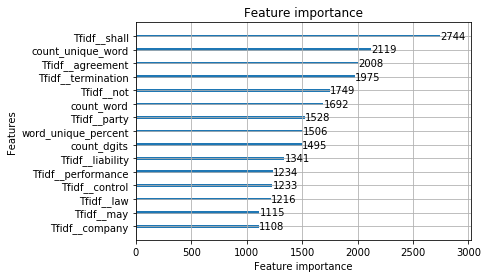

In [23]:
lgb.plot_importance(mod,max_num_features = 15)

In [24]:
lgbpred = mod.predict(testfinal)

/home/him4398/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
#report for each class

print(metrics.classification_report(test.Class , lgbpred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       100
          1       1.00      1.00      1.00       100
          2       1.00      1.00      1.00       100
          3       1.00      1.00      1.00       100
          4       1.00      1.00      1.00       100
          5       1.00      1.00      1.00       100
          6       1.00      1.00      1.00       100
          7       1.00      1.00      1.00       100
          8       1.00      1.00      1.00       100
          9       1.00      1.00      1.00       100

avg / total       1.00      1.00      1.00      1000



Confusion matrix, without normalization


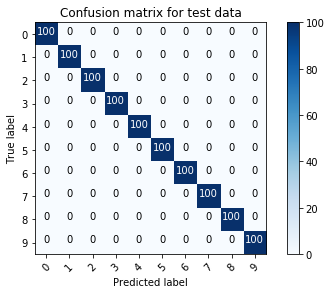

In [41]:
cm = metrics.confusion_matrix(test.Class,lgbpred)
plot_confusion_matrix(cm,range(10),title="Confusion matrix for test data")

### Logistic regression

In [45]:
clf = linear_model.LogisticRegression(solver='lbfgs' , C=2, tol=1e-6 , multi_class='multinomial')
clf.fit(trainfinal,train.Class)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=1e-06, verbose=0, warm_start=False)

In [46]:
pre = clf.predict(testfinal)

In [47]:
print(metrics.classification_report(test.Class,pre))


             precision    recall  f1-score   support

          0       0.97      0.98      0.98       100
          1       1.00      1.00      1.00       100
          2       0.99      0.98      0.98       100
          3       0.99      1.00      1.00       100
          4       0.98      0.99      0.99       100
          5       0.99      0.98      0.98       100
          6       0.99      0.98      0.98       100
          7       0.99      1.00      1.00       100
          8       0.99      0.99      0.99       100
          9       0.98      0.97      0.97       100

avg / total       0.99      0.99      0.99      1000



#### Top 10 features for each class given by LR

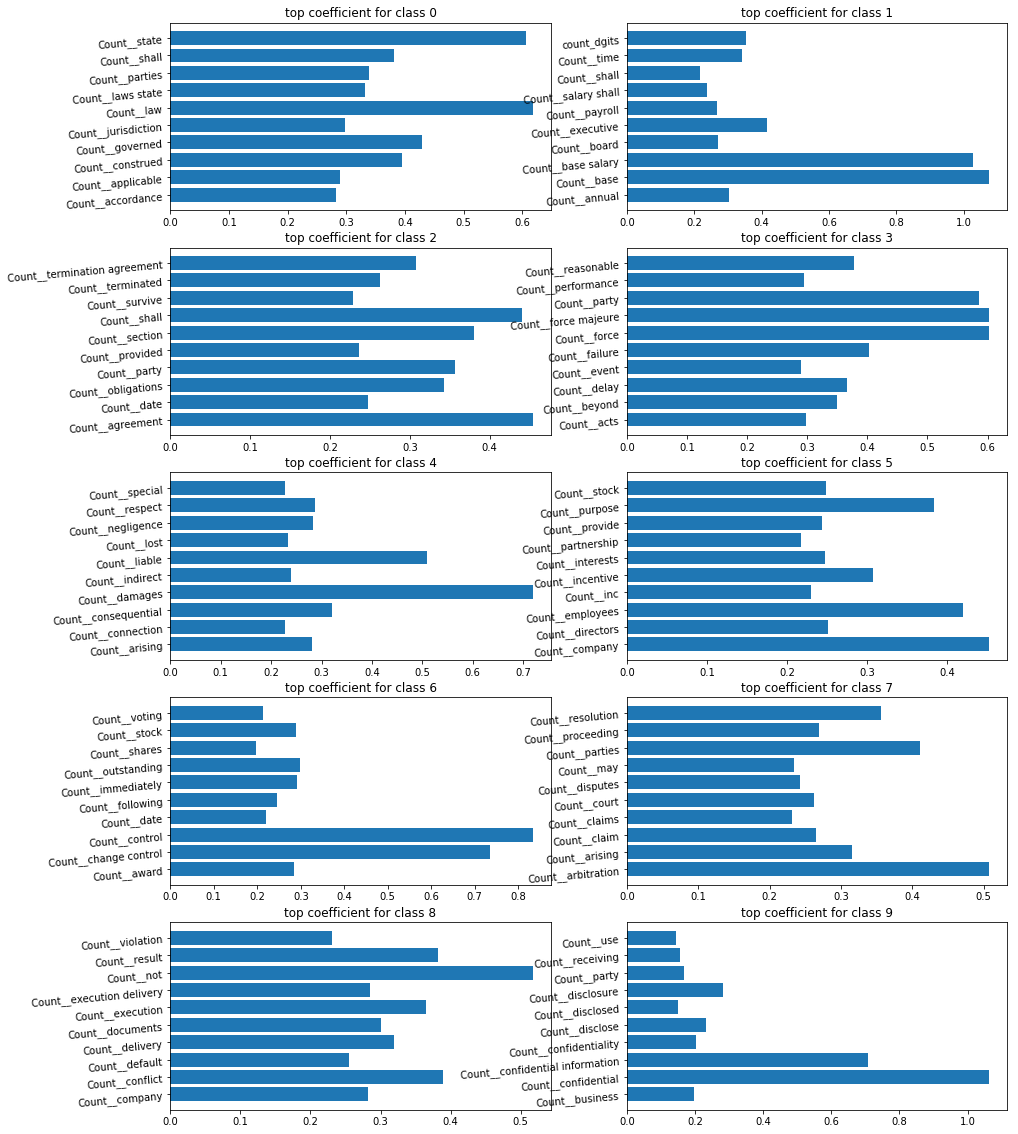

In [49]:
plt.figure(figsize=(15, 20))

for i in range(10):
    vect  = []
    value = []
    for v in np.argsort(clf.coef_[i])[-11:-1]:
        vect.append(vocab[v])
        value.append(clf.coef_[i][v])

    plt.subplot(5,2,i+1)
    plt.barh(vect,value)
    plt.yticks(size=10,rotation=5)
    plt.title("top coefficient for class {}".format(i))


Confusion matrix, without normalization


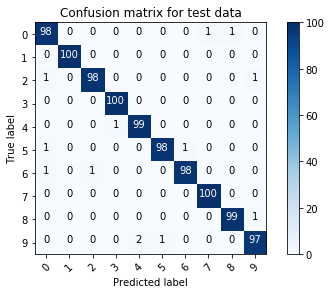

In [51]:
cm = metrics.confusion_matrix(test.Class,pre)
plot_confusion_matrix(cm,range(10),title="Confusion matrix for test data")

In [59]:
y_score = clf.decision_function(testfinal)
y = label_binarize(test.Class , classes=[0, 1, 2,3,4,5,6,7,8,9])
                   
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




/home/him4398/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


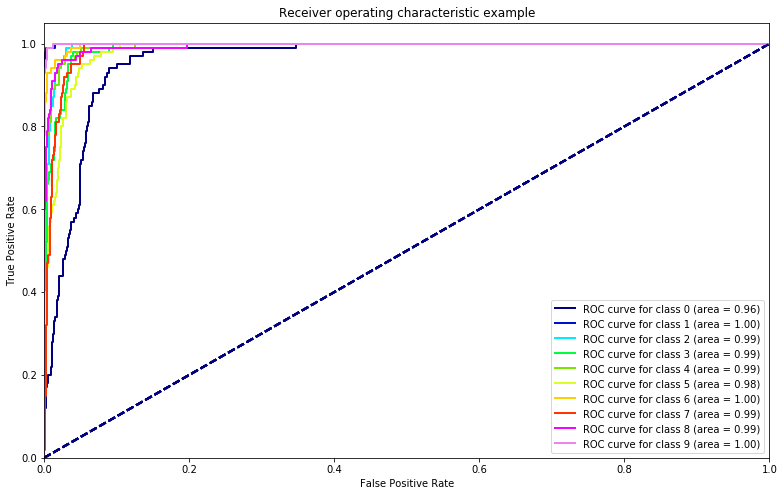

In [82]:
plt.figure(figsize=(13, 8))

colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 10)])

for i in range(10):
    lw = 2
    plt.plot(fpr[i], tpr[i], 
             lw=lw, label='ROC curve for class {} (area = {:.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")


#### Fun Fact:
1. The first 3 rows of test data exist in train data(index number in train data: [223,9661,9751]).
2. Logistic regression also gives Auc of 1 if the data is used without cleaning.

#### I thought of using the ensemble of both these model by wighted average in the end but the results are great, so dropped the idea.
#### I did not print the results of tunning lighgbm which show the train and test loss, you can run that if want to see.

### I don't know if data is that much predictable or there is overlapping of words, I didn't check for any leakage but results are unxpectedely good.